In [11]:
import numpy as np
import pandas as pd
import skimage.io as skimio
import skimage.color as skimcolor
import matplotlib.pyplot as plt
import os
import warnings

#### Read in data and modify data

In [2]:
local_path = os.getcwd()
img_dir = "./data/Images/"
trans_dir = "./data/Transcriptions/"
part_dir = "./data/Partitions/"

In [3]:
# get partitions (only use training for now)
with open(os.path.join(part_dir, "TrainLines.lst")) as f:
    training = f.read().splitlines()
with open(os.path.join(part_dir, "ValidationLines.lst")) as f:
    validation = f.read().splitlines()
with open(os.path.join(part_dir, "TestLines.lst")) as f:
    test = f.read().splitlines()

In [ ]:
# filenames
filenames = [f.replace(".txt", "") for f in os.listdir(trans_dir)]
filenames = [f for f in filenames if f in training]
data_df = pd.DataFrame({"filenames": filenames})
data_df["imgnames"] = [img_dir+f+".png" for f in data_df.filenames]
data_df["transnames"] = [trans_dir+f+".txt" for f in data_df.filenames]

In [ ]:
# images
def readBenthamImg(fn):
    im = skimio.imread(fn)
    rep_val = max(np.median(im[:,:,0]), np.mean(im[:,:,0]))
    im[im[:,:,3] == 0] = [rep_val, rep_val, rep_val, 255]
    im = skimcolor.rgb2gray(im)*255
    return im.astype("int")
data_df["images"] = [readBenthamImg(f) for f in data_df.imgnames]
data_df["imsizes"] = [i.shape for i in data_df.images]
data_df["heights"] = [i[0] for i in data_df.imsizes]
data_df["widths"] = [i[1] for i in data_df.imsizes]

In [4]:
# transcriptions
def readBenthamTrans(fn):
    return open(fn, "r").readline().replace("\n", "")
data_df["transcription"] = [readBenthamTrans(f) for f in data_df.transnames]

#### Get rid of unwanted rows

1833.0 181.0


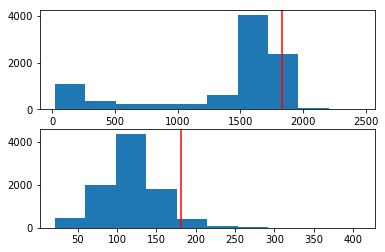

In [5]:
w95 = np.percentile(data_df.widths, 95)
h95 = np.percentile(data_df.heights, 95)
print(w95, h95)

# size columns
plt.subplot(211)
plt.hist(data_df.widths)
plt.axvline(x=w95, color="r")
plt.subplot(212)
plt.hist(data_df.heights)
plt.axvline(x=h95, color="r")
plt.show()

In [6]:
# get rid of the really big images
data_df = data_df[np.logical_and(data_df.widths < w95, data_df.heights < h95)]

# get rid of images with annoying characters
data_df["nonhex"] = [any([ord(i) > 127 for i in t]) 
                     for t in data_df.transcription]
data_df = data_df[np.logical_not(data_df.nonhex)]

#### Save new images

In [9]:
new_img_dir = local_path + "/data/Images_mod/"
if not os.path.isdir(new_img_dir):
    os.mkdir(new_img_dir)
data_df["new_img_path"] = [new_img_dir + f+".png" for f in data_df.filenames]

In [12]:
count = 0
for i in data_df.index:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        skimio.imsave(data_df.loc[i, "new_img_path"], data_df.loc[i, "images"])
    count += 1
    if count % 500 == 0: print(count, end="\t")

500	1000	1500	2000	2500	3000	3500	4000	4500	5000	5500	6000	6500	7000	7500	8000	

#### Save training file

In [13]:
export_df = data_df[["new_img_path", "transcription"]]
export_df.to_csv("./data/train.csv", sep="\t", index=False)

#### Find freqency of letters

In [15]:
letters = dict()

for tran in export_df.transcription:
    for l in list(tran):
        if l not in letters:
            letters[l] = 0
        letters[l] += 1
letters = sorted(letters.items(), key = lambda f: f[1], reverse=True)

In [16]:
print(letters)

[(' ', 75213), ('e', 37833), ('t', 27693), ('o', 23144), ('n', 21418), ('a', 21333), ('i', 21113), ('s', 18914), ('r', 17622), ('h', 16167), ('d', 9654), ('l', 9115), ('c', 9020), ('f', 8427), ('u', 8413), ('m', 6995), ('p', 6316), ('y', 4794), ('b', 4597), ('g', 4526), ('w', 4393), ('v', 3008), (',', 2665), ('.', 2555), (':', 1053), ('k', 1041), ('-', 854), ('I', 775), ('C', 718), ('T', 681), ('x', 660), ('"', 649), ('A', 615), ('S', 576), ('P', 471), ('=', 420), ('1', 418), ('_', 393), ('B', 392), ('M', 362), ('j', 360), ('O', 357), ('L', 337), ('q', 302), (';', 300), ('F', 289), ('H', 275), ('E', 271), ("'", 262), ('W', 255), ('2', 251), ('(', 228), (')', 222), ('N', 221), ('J', 209), ('G', 199), ('D', 196), ('3', 170), ('0', 150), ('7', 150), ('R', 138), ('&', 136), ('4', 135), ('9', 126), ('[', 109), (']', 108), ('8', 100), ('6', 98), ('z', 96), ('5', 87), ('?', 86), ('/', 63), ('Y', 58), ('<', 56), ('>', 56), ('V', 54), ('U', 40), ('+', 31), ('K', 30), ('Q', 27), ('|', 19), ('!',